In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
    lowerd = DFlow([NVPFlow(dim=k*(k-1)//2 + k, name='lowerd_flow_' + str(i)) for i in range(2)])
    ldiag = DFlow([NVPFlow(dim=k, name='ldiag_flow_' + str(i)) for i in range(4)])
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
                   lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=False):
        
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([LinearChol(dim=dim[0]*dim[1], name='lc', aux_vars=aux_vars)], 
                          init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    if i >= 1:
        aux = tf.concat([outputs[-1], outputs[-2]], 1)
#     elif i>= 2:
#         aux = tf.concat([outputs[-1], outputs[-2], outputs[-3]], 1)
    else:
        aux = outputs[-1]
    new = create_step_flow('step_flow' + str(i+1), aux, init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
aux

<tf.Tensor 'concat_17:0' shape=(1, 24) dtype=float64>

In [10]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [11]:
outputs

<tf.Tensor 'strided_slice_2:0' shape=(1, 20, 12) dtype=float64>

In [12]:
prior = PWalk.logdens(outputs)

In [13]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [14]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [15]:
logl = create_loglik2()

In [16]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [17]:
ent

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [18]:
df = dim[0]*dim[1]
pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [19]:
loss = -logl - prior + ent - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [20]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [21]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [22]:
sess = tf.InteractiveSession()

In [23]:
tf.global_variables_initializer().run()

In [24]:
prior.eval(), ent.eval(), logl.eval()

(-18776.224333148177, 681.3209599305612, -15781.036493276128)

In [25]:
loss.eval()

array([108.27728301])

In [26]:
np.set_printoptions(precision=4)

In [27]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[23697.3229,  -147.4871,    55.4281],
       [ -147.4871,   990.6215,   -39.2068],
       [   55.4281,   -39.2068,  3717.3064]])

In [28]:
# all_sum = tf.summary.merge_all()
# writer = tf.summary.FileWriter('/tmp/tfdbg')

In [50]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')
#     writer.add_summary(all_sum.eval())

[2.979]
[[ 1043.5451  -570.1126  -241.58  ]
 [ -570.1126  6281.5602 -2089.1563]
 [ -241.58   -2089.1563 25865.5762]]


[3.0393]
[[ 1085.0781 -2038.6644   276.9487]
 [-2038.6644 13951.4736   297.4141]
 [  276.9487   297.4141 38156.1618]]


[3.0635]
[[ 1554.2816  -724.1972  2791.7782]
 [ -724.1972  6348.6865  3119.0359]
 [ 2791.7782  3119.0359 37585.7519]]


[3.0297]
[[  633.1807    77.0744  1520.3288]
 [   77.0744  7528.8256  5982.7671]
 [ 1520.3288  5982.7671 68354.9966]]


[2.9541]
[[ 1993.7934  1585.1156  1362.2237]
 [ 1585.1156  7817.631   1644.3023]
 [ 1362.2237  1644.3023 37430.8917]]


[3.0679]
[[ 7.6126e+02 -1.0988e+03  1.1445e+03]
 [-1.0988e+03  5.4635e+03 -7.1600e+00]
 [ 1.1445e+03 -7.1600e+00  3.4071e+04]]


[3.0314]
[[ 2134.9632  -987.85    2608.969 ]
 [ -987.85    9885.9868 -8702.1295]
 [ 2608.969  -8702.1295 87027.8229]]


[3.0088]
[[ 1673.249  -1593.4281   188.4651]
 [-1593.4281  8854.3992   162.7027]
 [  188.4651   162.7027 46621.322 ]]


[3.0317]
[[ 1482.6747   238.3156

[3.0316]
[[  797.9987 -1112.9018  2288.0111]
 [-1112.9018 10142.7058 -5331.1821]
 [ 2288.0111 -5331.1821 44671.467 ]]


[3.1148]
[[   945.1929   -158.1712   -699.9465]
 [  -158.1712   5095.3445   -873.1633]
 [  -699.9465   -873.1633 102622.1653]]


[3.0138]
[[  934.0557  1650.6631   980.5112]
 [ 1650.6631 11878.0826  4230.8867]
 [  980.5112  4230.8867 70552.7662]]


[3.077]
[[ 1.7934e+03 -7.6719e+02 -2.5996e+01]
 [-7.6719e+02  6.3468e+03 -9.7891e+01]
 [-2.5996e+01 -9.7891e+01  3.4097e+04]]


[2.9699]
[[ 1676.6171 -1074.2202  3083.2577]
 [-1074.2202  7438.0199 -3203.1657]
 [ 3083.2577 -3203.1657 61260.2543]]


[3.1179]
[[  949.4684  -842.0807  -466.1371]
 [ -842.0807 12119.016  -3959.0301]
 [ -466.1371 -3959.0301 45295.5733]]


[3.0629]
[[ 7.5185e+02 -2.5300e+01 -3.0987e+02]
 [-2.5300e+01  5.1406e+03  1.5820e+03]
 [-3.0987e+02  1.5820e+03  7.4388e+04]]


[2.9965]
[[  608.3573   193.8017  -925.9717]
 [  193.8017  5598.1125 -5416.9538]
 [ -925.9717 -5416.9538 30120.0603]]


[2.9881]
[[ 19

[3.0778]
[[ 2191.7658 -1194.929  -1043.0063]
 [-1194.929   6223.9951   408.9768]
 [-1043.0063   408.9768 25627.1132]]


[3.1102]
[[ 1693.4039  1407.1641 -2379.681 ]
 [ 1407.1641  7182.9028  2904.8795]
 [-2379.681   2904.8795 44339.1388]]


[3.0303]
[[ 1045.9258  -159.2451   446.6082]
 [ -159.2451  5521.7681 -3752.0572]
 [  446.6082 -3752.0572 56801.0184]]


[3.0059]
[[ 9.9984e+02 -1.1062e+03 -3.0864e+01]
 [-1.1062e+03  7.3876e+03 -6.3116e+03]
 [-3.0864e+01 -6.3116e+03  3.3695e+04]]


[3.0292]
[[  974.8334  -131.7825 -1024.2024]
 [ -131.7825  6079.1266 -1512.6403]
 [-1024.2024 -1512.6403 61606.6533]]


[3.0006]
[[ 1079.8888   157.2086  3597.1183]
 [  157.2086  9286.4495  4655.2275]
 [ 3597.1183  4655.2275 51272.4823]]


[3.0477]
[[8.1192e+02 4.7549e+02 3.6242e+01]
 [4.7549e+02 7.0139e+03 8.3929e+03]
 [3.6242e+01 8.3929e+03 9.5898e+04]]


[3.0027]
[[ 1249.8205 -1204.6684 -2197.1282]
 [-1204.6684  4930.9106 -1303.1258]
 [-2197.1282 -1303.1258 67967.1027]]


[3.0137]
[[ 2262.3398  -535.593

[3.0376]
[[9.5547e+02 1.0413e+00 1.0150e+03]
 [1.0413e+00 9.1262e+03 5.7874e+03]
 [1.0150e+03 5.7874e+03 2.7591e+04]]


[3.0793]
[[ 1131.8637   416.645    389.3986]
 [  416.645  13577.8476 10673.1363]
 [  389.3986 10673.1363 65132.2769]]


[3.0683]
[[ 1605.5502  -676.0131   166.2247]
 [ -676.0131  7805.3503 -5039.044 ]
 [  166.2247 -5039.044  39635.1969]]


[3.0541]
[[ 1705.0599  -317.5071   423.6387]
 [ -317.5071  9209.9288  9324.5647]
 [  423.6387  9324.5647 62020.273 ]]


[2.9907]
[[ 1263.3947  1971.4096 -1504.4893]
 [ 1971.4096 10806.7467  -653.2582]
 [-1504.4893  -653.2582 43708.9104]]


[3.0159]
[[  482.3473  -312.3082  -884.2611]
 [ -312.3082  5911.5319  4179.4161]
 [ -884.2611  4179.4161 59999.2612]]


[3.0797]
[[ 1337.8624  -833.0665  1220.694 ]
 [ -833.0665  4694.9927  -183.6502]
 [ 1220.694   -183.6502 55509.1618]]


[3.0214]
[[ 1120.9156  -215.3456   974.9414]
 [ -215.3456 11508.3277 -4294.7981]
 [  974.9414 -4294.7981 60403.8743]]


[3.0713]
[[ 1487.7105   977.3955  1312.9

[3.019]
[[ 1372.6539  -125.714    740.3353]
 [ -125.714   4928.8102  3698.6472]
 [  740.3353  3698.6472 33228.4695]]


[3.0154]
[[ 1090.8766   870.5824  1216.5826]
 [  870.5824  9973.0476  1275.5804]
 [ 1216.5826  1275.5804 32460.5229]]


[3.1853]
[[ 1549.5058  -777.9025  2073.1685]
 [ -777.9025  7754.2063   303.467 ]
 [ 2073.1685   303.467  41409.0413]]


[3.125]
[[  694.5298   711.2158 -1017.0163]
 [  711.2158 12141.7595 -7787.9876]
 [-1017.0163 -7787.9876 51419.7485]]


[3.0574]
[[ 1175.6329  -298.3849  1856.7199]
 [ -298.3849  9788.4194 -2443.7441]
 [ 1856.7199 -2443.7441 73613.6491]]


[3.0582]
[[  954.4771  -163.4008   394.7615]
 [ -163.4008 13208.3558 -6974.9615]
 [  394.7615 -6974.9615 52877.0528]]


[3.0964]
[[  670.8274  1097.0935  -241.7007]
 [ 1097.0935  9245.2078 -9234.7589]
 [ -241.7007 -9234.7589 53768.0424]]


[3.0449]
[[  873.8075  1196.5499 -1485.4975]
 [ 1196.5499  8349.8507 -5457.7231]
 [-1485.4975 -5457.7231 58308.5248]]


[3.0408]
[[  907.7232  -633.7412  -833.853

[3.0923]
[[  737.7812 -1267.456  -1700.0582]
 [-1267.456   9072.3399  9436.4594]
 [-1700.0582  9436.4594 56279.8435]]


[3.0581]
[[ 1520.5738  1503.9031   991.6932]
 [ 1503.9031 12125.9287 -5139.2098]
 [  991.6932 -5139.2098 47339.5684]]


[2.9948]
[[ 1013.3961 -1617.2195 -1350.5157]
 [-1617.2195  6853.254   6798.398 ]
 [-1350.5157  6798.398  78313.8699]]


[3.0209]
[[ 2280.721    693.7968 -4436.199 ]
 [  693.7968  6543.4375 -7518.203 ]
 [-4436.199  -7518.203  53437.0587]]


[3.0848]
[[ 1003.7702   147.1442   418.9278]
 [  147.1442  6561.3573   523.3369]
 [  418.9278   523.3369 28145.4712]]


[3.0303]
[[ 5.1817e+02 -2.7885e+01  1.5701e+03]
 [-2.7885e+01  8.2485e+03 -4.3131e+03]
 [ 1.5701e+03 -4.3131e+03  2.8312e+04]]


[2.953]
[[  1051.5535   1587.8489  -2414.6759]
 [  1587.8489  10387.3094 -20120.7375]
 [ -2414.6759 -20120.7375  68640.919 ]]


[3.1412]
[[ 1508.8515 -1878.4124  1242.6226]
 [-1878.4124 14177.6713 -2143.3561]
 [ 1242.6226 -2143.3561 39538.4959]]


[3.0548]
[[ 1197.6222  

[3.0339]
[[ 3020.654  -1409.5189 -2353.2347]
 [-1409.5189  7951.0535  3190.6824]
 [-2353.2347  3190.6824 39774.9755]]


[3.102]
[[ 1244.8873   849.7971 -2570.6514]
 [  849.7971  6060.7493 -6671.9812]
 [-2570.6514 -6671.9812 44976.4793]]


[3.0511]
[[  941.3184  -279.2542  1534.4404]
 [ -279.2542  8142.168  -1456.7143]
 [ 1534.4404 -1456.7143 55086.9669]]


[3.0843]
[[ 1911.8037   502.158   3207.5828]
 [  502.158   6732.8931  1335.1265]
 [ 3207.5828  1335.1265 39907.8642]]


[3.0084]
[[ 1836.3347  1080.4385   170.3099]
 [ 1080.4385  7421.2682   238.0314]
 [  170.3099   238.0314 79503.2594]]


[3.1061]
[[  796.868    178.9148 -1256.8001]
 [  178.9148 18740.9792  3915.9635]
 [-1256.8001  3915.9635 77327.884 ]]


[3.0302]
[[ 1432.5686  -319.983   1202.0392]
 [ -319.983  11338.3254 -8810.1447]
 [ 1202.0392 -8810.1447 62161.3018]]


[3.0483]
[[  953.4835   -95.9295 -3239.36  ]
 [  -95.9295  3398.7331 -5237.0998]
 [-3239.36   -5237.0998 81534.4856]]


[3.0375]
[[ 1597.872   2081.2501 -1961.26

[2.9894]
[[ 1483.2369  -691.0777 -2327.9397]
 [ -691.0777  6119.0047  2902.4553]
 [-2327.9397  2902.4553 76831.8272]]


[3.0058]
[[ 1123.5093  -876.3965  1557.3804]
 [ -876.3965  8654.6671  7612.2926]
 [ 1557.3804  7612.2926 74617.8268]]


[2.992]
[[ 1559.7513  -866.7297  2455.0031]
 [ -866.7297  6736.8382   937.9845]
 [ 2455.0031   937.9845 46513.8011]]


[3.0003]
[[ 1055.5774   692.0556   831.159 ]
 [  692.0556  7236.0398  2854.8019]
 [  831.159   2854.8019 49731.4203]]


[3.0557]
[[ 1558.0842  1715.2082  5369.1054]
 [ 1715.2082  7422.7573  9051.8629]
 [ 5369.1054  9051.8629 67480.7127]]


[3.1278]
[[ 1395.0958    76.0275  2223.1325]
 [   76.0275  6465.7927 -6129.9748]
 [ 2223.1325 -6129.9748 54869.6389]]


[3.0279]
[[  727.9888   454.4432  -499.3998]
 [  454.4432  5298.137   1881.7695]
 [ -499.3998  1881.7695 67616.6215]]


[2.983]
[[  1644.8063   -380.1299  -3754.8574]
 [  -380.1299  10187.3402   6580.1289]
 [ -3754.8574   6580.1289 109193.6461]]


[2.9413]
[[ 1172.1111  -517.9681 

KeyboardInterrupt: 

In [30]:
# saver = tf.train.Saver()

In [51]:
saver = tf.train.Saver()
saver.save(sess,'/home/nikita/tmp/rdata3')

'/home/nikita/tmp/rdata3'

In [44]:
ss = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval())
    ss.append(np.sqrt(np.diag(a)))
ss = np.array(ss)

In [45]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.0402, 0.0159, 0.0062, 0.0034, 0.0023, 0.0017, 0.0015, 0.0012,
        0.0011, 0.001 , 0.001 , 0.0008]),
 array([0.009 , 0.0035, 0.0013, 0.0007, 0.0005, 0.0003, 0.0003, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0001]))

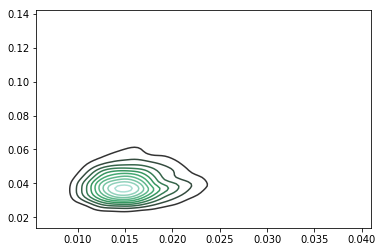

In [46]:
sns.kdeplot(ss[:,1], ss[:,0])
plt.show()

In [35]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [47]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [48]:
samples.shape

(3000, 20, 3, 4)

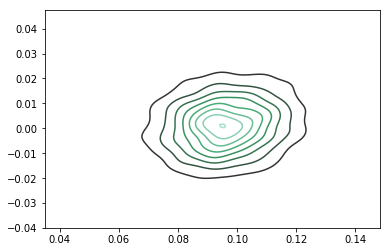

In [49]:
sns.kdeplot(samples[:,0,2,0], samples[:,11,0,3])
plt.show()

In [139]:
samples[:,10,2,0].mean()

0.09639029882481966

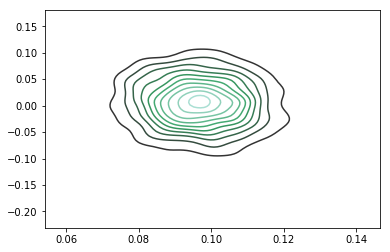

In [140]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

In [83]:
t = 10
# params[t]

In [84]:
np.mean(samples[:,t], axis=0)

array([[ 3.3247e-03, -7.3668e-03,  6.3002e-03,  1.1010e-02],
       [ 4.5848e-03, -3.7239e-04,  9.8147e-03,  3.6363e-03],
       [ 9.8738e-02, -1.8441e-03,  9.1986e-01,  1.1776e-04]])

In [85]:
np.std(samples[:,t], axis=0)

array([[0.0571, 0.032 , 0.0175, 0.0123],
       [0.0097, 0.0084, 0.0086, 0.0065],
       [0.0108, 0.0047, 0.024 , 0.003 ]])

In [163]:
np.mean(samples[:,t], axis=0)

array([[-0.2617, -0.0514, -0.1421, -1.1013],
       [ 0.0716,  0.1932,  0.6169,  0.2148],
       [ 0.2826, -0.0293,  0.8549,  0.9093]])

In [164]:
np.std(samples[:,t], axis=0)

array([[0.1349, 0.0932, 0.1238, 0.3107],
       [0.0814, 0.0982, 0.1407, 0.1506],
       [0.0623, 0.039 , 0.0645, 0.3178]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


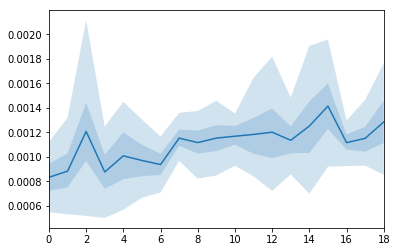

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


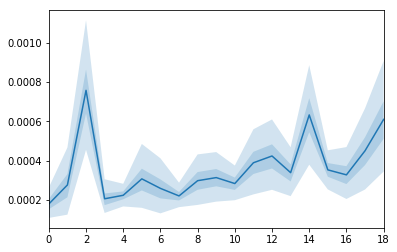

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


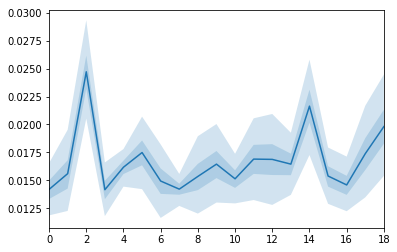

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

In [ ]:
tf.pow()